In [ ]:
from math import sqrt
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt

In [ ]:
from math import sqrt

# ==== Параметры водохранилища ====
A0_km2 = 154 # Площадь Иркутского водохранилища

# ==== Входные данные ====
# Приток воды (м³/с)
Q_in = [
    -500, -100, -50, 50, 300, 400, 250, 450, 400,
    200, 200, 1600, 1600, 1700, 1600, 1600, 2300,
    4800, 4900, 4630, 4000, 3100, 4800, 2500, 2000,
    2400, 3700, 2200, 3100, 1500, 1500, 1100, 500, 1300
]
# Общий расход (м³/с)
Q_out = [
    1630,1600,1600,1600,1600,1630,1635,1641,1600,1600,1600,1900,2000,
    1700,1800,1800,1700,1700,1700,2000,2000,2000,2000,2000,2000,1500,
    1300,1300,1300,1400,1400,1500,1800,2000
]

# Месячные суммы осадков и испарения (мм/мес)
P_mm = [11, 10, 15, 26, 40, 69, 99, 104, 62, 15, 5, 8]
E_mm = [1, 1, 5, 10, 25, 45, 50, 45, 30, 15, 5, 8]

# Начальный уровень воды
h0 = 456.58

# Реальный уровень воды
h_real = [
    456.58,456.55,456.46,456.46,456.44,456.36,456.35,456.33,456.27,
    456.26,456.24,456.19,456.18,456.18,456.18,456.18,456.19,456.33,
    456.34,456.40,456.52,456.53,456.58,456.63,456.63,456.65,456.81,
    456.81,456.87,456.92,456.93,456.91,456.85
]
size = 33
# ==== Модель ====
def simulate(alpha, n, kf):
  dt = 10 * 24 * 3600 # шаг = 10 суток

  curMonth = -1
  A0_m2 = A0_km2 * 1e6
  h = h0
  h_predict = []
  for i in range(size):
      h_predict.append(h)

      # шаг месяца (каждые 3 точки примерно месяц)
      if i % 3 == 0:
          curMonth += 1

      # Приток/сброс в м³/с
      Qin = Q_in[i]
      Qout = Q_out[i]

      # Атмосферный вклад
      # делим помесячную сумму на 3 трехдневки
      P = P_mm[curMonth] / 3
      E = E_mm[curMonth] / 3

      #area = A0_m2
      area = A0_m2 * n * alpha * ((h / h0) ** (n - 1))

      Q_atm = area * (P - E) * 1e-3  # мм -> метры -> м³

      Q_loss = kf * h

      # Баланс объёмов за шаг dt
      dV = (Qin - Qout) * dt - Q_loss + Q_atm

      # Приращение уровня
      dh = dV / area
      h += dh
  return h_predict

In [ ]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

def std(a, b):
    return np.std(a - b)

def max_diff(a, b):
    return np.abs(a - b).max()

In [ ]:
alpha_min = 50
alpha_max = 200
alpha_num = 100

n_min = 1
n_max = 3
n_num = 200

kf_min = 1e-11
kf_max = 1e6
kf_num = 5

alphas = np.linspace(alpha_min, alpha_max, alpha_num)
ns = np.linspace(n_min, n_max, n_num)
kfs = np.linspace(kf_min, kf_max, kf_num)

best = {"alpha": None, "n": None, "kf": None, "max_diff": float("inf"), "rmse": float("inf")}

_h_real = np.array(h_real, dtype=float)
for n in ns:
    for kf in kfs:
        for alpha in alphas:
            h_pred = simulate(alpha, n, kf)
            if h_pred is None:
                continue

            h_pred = np.array(h_pred, dtype=float)
            err = rmse(h_pred, _h_real)
            diff = max_diff(h_pred, _h_real)
            if (np.isfinite(err) and np.isfinite(diff) and
                err < best["rmse"] and diff < best["max_diff"]
                ):
                best = {"alpha": alpha, "n": n, "kf": kf, "max_diff" : diff, "rmse": err}

print(f"alpha = {best['alpha']}")
print(f"n     = {best['n']}")
print(f"kf    = {best['kf']}")
print("=== Metrics ===")
print(f"RMSE:     {best['rmse']} м")
print(f"max_diff: {best['max_diff']} м")

alpha = 74.24242424242425
n     = 2.909547738693467
kf    = 1e-11
=== Metrics ===
RMSE:     0.04085131727262846 м
max_diff: 0.1080164613736656 м


In [ ]:
alpha = 73.18090452261306
n     = 2.969849246231156
kf    = 1e-06
h_predict = simulate(alpha, n, kf)

In [ ]:
months = [12] + list(range(1, 11))
days = [1, 11, 21]
dates = [f"{day:02}.{month:02}" for month in months for day in days]
dates = dates[:size]

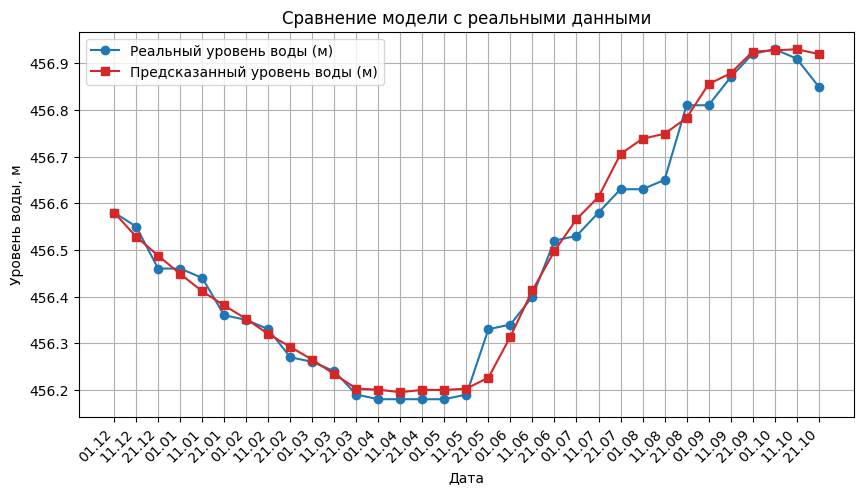

In [ ]:
h_real = np.array(h_real, dtype=float)
h_predict = np.array(h_predict, dtype=float)

df = pd.DataFrame({
    "i": np.arange(size),
    "h_real": h_real,
    "h_model": h_predict,
    "diff": h_predict - h_real
})

plt.figure(figsize=(10,5))
plt.plot(df['i'], df['h_real'], marker='o', label='Реальный уровень воды (м)')
plt.plot(df['i'], df['h_model'], color='#d62728', marker='s', label='Предсказанный уровень воды (м)')

plt.xticks(ticks=df['i'], labels=dates, rotation=45, ha='right')

plt.xlabel("Дата")
plt.ylabel("Уровень воды, м")
plt.title("Сравнение модели с реальными данными")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
_max_diff = max_diff(h_real, h_predict)
_std_diff = std(h_real, h_predict)
_rmse = rmse(h_real, h_predict)

print(f'max_diff: {(_max_diff * 100):.2f}см')
print(f'std_diff: {(_std_diff * 100):.2f}см')
print(f'rmse:     {(_rmse * 100):.2f}см')

max_diff: 10.82см
std_diff: 3.86см
rmse:     4.08см
